In [164]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ConvLSTM2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from scipy.spatial import distance
from sklearn.preprocessing import normalize
from PIL import Image
from scipy.spatial.distance import cdist # 创建函数来查找测试图像的最近邻
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import types
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # 取消大小限制

In [165]:
# 加载不同的 CSV 文件
try:
    # 读取训练和验证数据
    style_train_data = pd.read_csv('wikiart_csv/Style_train.csv', header=None)
    style_train_data.columns = ['image_path', 'class_index']
    
    style_val_data = pd.read_csv('wikiart_csv/Style_val.csv', header=None)
    style_val_data.columns = ['image_path', 'class_index']
    
    # 查看数据的前几行
    print("成功加载 CSV 文件！")
    print(style_train_data.head())
    print(style_val_data.head())
    
    # 提取所有类别，进行独热编码处理
    # all_labels = pd.concat([style_train_data['class_index'], style_val_data['class_index']])
    # num_classes = all_labels.nunique()  # 获取不同类别的数量
    
    # 创建一个 LabelEncoder 将标签转化为独热编码
    # label_encoder = LabelEncoder()
    # all_labels_encoded = label_encoder.fit_transform(all_labels)
    
    # 为训练和验证数据添加独热编码标签
    # 使用 pd.get_dummies 方法来生成独热编码
    # 注意: pd.get_dummies 输出的是一个 DataFrame，需要将其单列提取出来并展平为数组
    # style_train_data['one_hot_label'] = pd.get_dummies(style_train_data['class_index']).values.tolist()
    # style_val_data['one_hot_label'] = pd.get_dummies(style_val_data['class_index']).values.tolist()

    # 查看独热编码后的数据
    print("训练数据与标签:")
    print(style_train_data[['image_path', 'class_index']].head())
    print("验证数据与标签:")
    print(style_val_data[['image_path', 'class_index']].head())

except FileNotFoundError as e:
    print(f"找不到 CSV 文件: {e}")
except pd.errors.EmptyDataError:
    print("CSV 文件为空！")
except pd.errors.ParserError:
    print("CSV 文件解析错误！")


成功加载 CSV 文件！
                                          image_path  class_index
0  Impressionism/edgar-degas_landscape-on-the-orn...           12
1         Realism/camille-corot_mantes-cathedral.jpg           21
2  Abstract_Expressionism/gene-davis_untitled-197...            0
3      Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg           24
4  Impressionism/maurice-prendergast_paris-boulev...           12
                                          image_path  class_index
0  Impressionism/edgar-degas_dancers-on-set-1880.jpg           12
1      Impressionism/claude-monet_water-lilies-6.jpg           12
2  Impressionism/giovanni-boldini_a-guitar-player...           12
3  Impressionism/john-singer-sargent_at-torre-gal...           12
4  Impressionism/john-singer-sargent_artist-in-th...           12
训练数据与标签:
                                          image_path  class_index
0  Impressionism/edgar-degas_landscape-on-the-orn...           12
1         Realism/camille-corot_mantes-cathedral.jpg  

In [166]:
data_dir = 'wikiart'  # 数据目录
if not os.path.exists(data_dir):
    print(f"数据目录不存在: {data_dir}")
else:
    print(f"数据目录存在: {data_dir}")


数据目录存在: wikiart


In [167]:
# 调整图像大小
img_size = (128, 128)  
batch_size = 32

In [168]:
class ImageLabelGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_frame, data_dir, batch_size, img_size, shuffle=True, num_classes=10):
        self.data_frame = data_frame
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes  
        self.indexes = np.arange(len(self.data_frame))

    def __len__(self):
        # 返回每个 epoch 需要多少步
        return int(np.floor(len(self.data_frame) / self.batch_size))

    def __getitem__(self, index):
        max_attempts = 3  # 最多尝试 3 次
        attempts = 0

        while attempts < max_attempts:
            batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
            batch_images = []
            batch_labels = []

            for i in batch_indexes:
                img_path = os.path.join(self.data_dir, self.data_frame.iloc[i, 0])
                try:
                    img = load_img(img_path, target_size=self.img_size)
                    img = img_to_array(img) / 255.0  # 归一化
                    label = self.data_frame.iloc[i, 1]  # 获取标签
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue  # 跳过无法加载的图像
                
                batch_images.append(img)
                batch_labels.append(label)
            
            # 打印每个批次的图像和标签数量
            print(f"加载的批次：{len(batch_images)} 图像，{len(batch_labels)} 标签")

            # 确保批次中的图像和标签数量一致
            if len(batch_images) == self.batch_size:
                # 返回图像和标签，标签使用 one-hot 编码
                return np.array(batch_images), to_categorical(np.array(batch_labels), num_classes=self.num_classes)

            attempts += 1
            print(f"尝试加载失败，重新尝试第 {attempts} 次...")

        # 如果连续几次都失败，则抛出异常
        raise ValueError("连续几次尝试后仍无法加载有效数据，请检查数据路径和格式！")

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            print("已打乱数据顺序")
        # 当数据不足以完成当前批次时，确保生成器可以重新迭代数据集
        self.indexes = np.arange(len(self.data_frame))  # 确保索引每个 epoch 都能循环



In [169]:
# 设置类别数
num_classes_style = len(style_train_data['class_index'].unique())

# 使用生成器加载训练数据和验证数据
# 创建生成器
# 创建生成器
train_gen_style = ImageLabelGenerator(style_train_data, data_dir, batch_size, img_size, shuffle=True, num_classes=num_classes_style)
val_gen_style = ImageLabelGenerator(style_val_data, data_dir, batch_size, img_size, shuffle=False, num_classes=num_classes_style)

# 查看数据
print("Style 类别数:", num_classes_style)

Style 类别数: 27


In [170]:
# Check value for image pixel 
# Notice that they already within 0-255
image_batch_original, labels_batch_original = next(iter(train_gen_style))
first_image = image_batch_original[0]

print("The shape for original image batch is", image_batch_original.shape,
      "\nThis means that there are",image_batch_original.shape[0],"images in a training batch,",
      "with size of",image_batch_original.shape[1],"by",image_batch_original.shape[2] )

print("\nUse the 1st image inside the training batch as an example.",
      "\nThe shape for original label batch is", labels_batch_original.shape,
      "\nThe minimum value for original pixel is", np.min(first_image),
      "\nThe maximum value for original pixel is", np.max(first_image),
      "\nThe mean value for original pixel is", np.mean(first_image),
      "\nThe standard derivative value for original pixel is", np.std(first_image))

加载的批次：32 图像，32 标签
The shape for original image batch is (32, 128, 128, 3) 
This means that there are 32 images in a training batch, with size of 128 by 128

Use the 1st image inside the training batch as an example. 
The shape for original label batch is (32, 27) 
The minimum value for original pixel is 0.0 
The maximum value for original pixel is 1.0 
The mean value for original pixel is 0.4173235 
The standard derivative value for original pixel is 0.25249636


### ConvLSTM
- 卷积部分 (Conv2D): 提取图像的空间特征。
- LSTM 部分: 图像的局部特征序列

In [171]:
# 自定义生成器，扩展时间步维度
def add_time_step_dimension(generator):
    for images, labels in generator:
        #print(f"当前批次：{images.shape}, 标签：{labels.shape}")
        # 增加时间步维度: (batch_size, 128, 128, 3) -> (batch_size, 1, 128, 128, 3)
        images = np.expand_dims(images, axis=1)  # 为了符合 ConvLSTM2D 的输入
        yield images, labels

train_gen = add_time_step_dimension(train_gen_style)
val_gen = add_time_step_dimension(val_gen_style)

# 创建 ConvLSTM 模型
model = Sequential()

# ConvLSTM2D 层
time_steps = 1  # 时间步
input_shape = (time_steps, img_size[0], img_size[1], 3)
model.add(ConvLSTM2D(filters=32, 
                    kernel_size=(3, 3), 
                    activation='relu', 
                    input_shape=input_shape, 
                    return_sequences=False))  # 不返回序列

# 批归一化
model.add(BatchNormalization())

# 卷积层
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.L2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout 层
model.add(Dropout(0.3))

# 展平层
model.add(Flatten())  # 展平层，将多维的输入一维化
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# 输出层
model.add(Dense(num_classes_style, activation='softmax', 
                kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.001)))  

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0003), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_10 (ConvLSTM2D)     │ (None, 126, 126, 32)   │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 126, 126, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 126, 126, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 59, 59, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 107648)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    27,558,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 27)             │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,915,291 (106.49 MB)

 Trainable params: 27,915,227 (106.49 MB)

 Non-trainable params: 64 (256.00 B)

In [172]:
train_sample_count = len(style_train_data)
val_sample_count = len(style_val_data)

print("训练集样本数:", train_sample_count)
print("验证集样本数:", val_sample_count)

# 计算每个 epoch 的步数
#steps_per_epoch = int(np.ceil(train_sample_count / batch_size))
#validation_steps = int(np.ceil(val_sample_count / batch_size))
steps_per_epoch = 5 #50
validation_steps = 3


print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

训练集样本数: 57025
验证集样本数: 24421
steps_per_epoch: 5
validation_steps: 3


In [173]:
# 训练模型
history = model.fit(
    train_gen,
    epochs= 3,#35,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

加载的批次：32 图像，32 标签
Epoch 1/3
加载的批次：32 图像，32 标签
1/5 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.0938 - loss: 4.5004加载的批次：32 图像，32 标签
2/5 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.0938 - loss: 4.5629加载的批次：32 图像，32 标签
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.0972 - loss: 4.5513加载的批次：32 图像，32 标签
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.0918 - loss: 4.5326加载的批次：32 图像，32 标签
加载的批次：32 图像，32 标签
加载的批次：32 图像，32 标签
加载的批次：32 图像，32 标签
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 605ms/step - accuracy: 0.0900 - loss: 4.5222 - val_accuracy: 0.0000e+00 - val_loss: 4.4511
Epoch 2/3
加载的批次：32 图像，32 标签
加载的批次：32 图像，32 标签
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.1562 - loss: 4.2698加载的批次：32 图像，32 标签
加载的批次：32 图像，32 标签
2/5 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 0.1250 - loss: 4.2763加载的批次：32 图像，32 标签
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.1042 - loss: 4.2725加载的批次：32 图像，32 标签
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.0957 - loss: 4.2644加载的批次：32 图像，32 标签

In [174]:
test_loss, test_accuracy = model.evaluate(val_gen, steps=validation_steps)
print(f'验证集损失: {test_loss}, 验证集准确率: {test_accuracy}')


加载的批次：32 图像，32 标签
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1250 - loss: 4.3700加载的批次：32 图像，32 标签
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.1250 - loss: 4.3694加载的批次：32 图像，32 标签
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.1250 - loss: 4.3690
加载的批次：32 图像，32 标签
验证集损失: 4.368682384490967, 验证集准确率: 0.125


In [175]:
# 确保预测时正确地收集 y_true 和 y_pred
y_true = []
y_pred = []

for batch_images, batch_labels in val_gen:
    # 只取 batch_labels 进行标签收集
    batch_labels = np.argmax(batch_labels, axis=1)  # 转化为类索引
    y_true.extend(batch_labels)  # 收集真实标签

    # 打印每个批次的预测结果，确保预测过程是有效的
    batch_predictions = model.predict(batch_images)
    batch_predictions = np.argmax(batch_predictions, axis=1)  # 获取每个预测的类别索引
    y_pred.extend(batch_predictions)  # 收集预测标签

    # 打印每批次的预测和真实标签，调试用
    print(f"真实标签: {batch_labels}")
    print(f"预测标签: {batch_predictions}")

# 确保 y_true 和 y_pred 不为空
print(f"最终真实标签的数量: {len(y_true)}")
print(f"最终预测标签的数量: {len(y_pred)}")


加载的批次：32 图像，32 标签
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
真实标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
预测标签: [ 3  3  3  3  3  3  3  3  3  3  3 12 21  3  3 12  3 12  3  3  3  3  3  3
  3  3  3 12  3  3 12  3]
加载的批次：32 图像，32 标签
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
真实标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
预测标签: [ 3  3  3  3  3  3  3  3  3  3  3 12  3  3  3  3  3  3  3  3  3  3  3  3
  3 12  3 12  3  3  3  3]
加载的批次：32 图像，32 标签
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
真实标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
预测标签: [ 3 12  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3 12  3  3 12 12  3 12]
加载的批次：32 图像，32 标签
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
真实标签: [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12]
预测标签: [12  3  3  3  3  3  3  3  3 12  3 

In [180]:
# 3. 计算并打印分类报告
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       834
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        33
           3       0.06      0.95      0.12      1300
           4       0.00      0.00      0.00      1272
           5       0.00      0.00      0.00       484
           6       0.00      0.00      0.00       144
           7       0.00      0.00      0.00       670
           8       0.00      0.00      0.00       417
           9       0.00      0.00      0.00      2020
          10       0.00      0.00      0.00       280
          11       0.00      0.00      0.00       402
          12       0.10      0.13      0.11      3406
          13       0.00      0.00      0.00       383
          14       0.00      0.00      0.00       401
          15       0.00      0.00      0.00       716
          16       0.00      0.00      0.00        94
          17       0.00    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [181]:
# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 打印混淆矩阵
print("混淆矩阵:")
print(cm)

混淆矩阵:
[[   0    0    0  748    0    0    0    0    0    0    0    0   83    0
     0    0    0    0    0    0    0    3    0    0    0    0    0]
 [   0    0    0   27    0    0    0    0    0    0    0    0    1    0
     0    0    0    0    0    0    0    1    0    0    0    0    0]
 [   0    0    0   27    0    0    0    0    0    0    0    0    6    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0 1231    0    0    0    0    0    0    0    0   69    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0  607    0    0    0    0    0    0    0    0  564    0
     0    0    0    0    0    0    0  101    0    0    0    0    0]
 [   0    0    0  379    0    0    0    0    0    0    0    0   95    0
     0    0    0    0    0    0    0   10    0    0    0    0    0]
 [   0    0    0  124    0    0    0    0    0    0    0    0   18    0
     0    0    0    0    0    0    0    2    0    0    0    0    0]
 [   0    0   

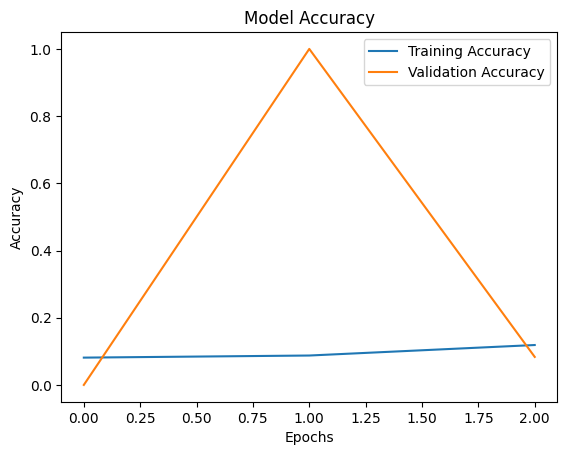

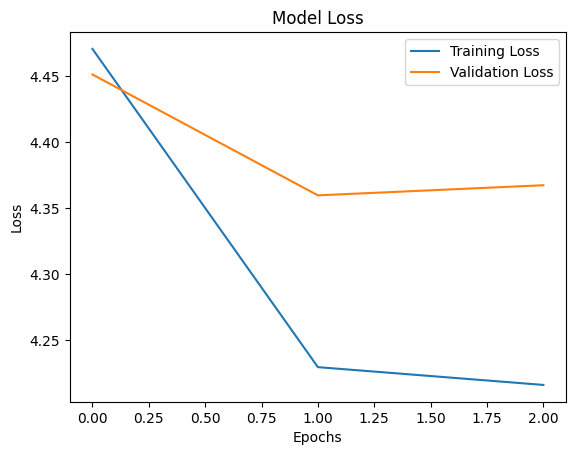

In [182]:
# 绘制准确率曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [183]:
class_indices = {v: k for k, v in enumerate(style_val_data['class_index'].unique())}
class_names = list(class_indices.keys())

In [185]:
print(f"最大真实标签值: {max(y_true)}")
print(f"最大预测标签值: {max(y_pred)}")


最大真实标签值: 26
最大预测标签值: 21


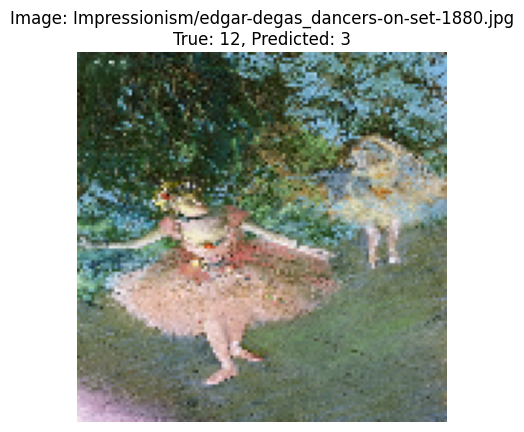

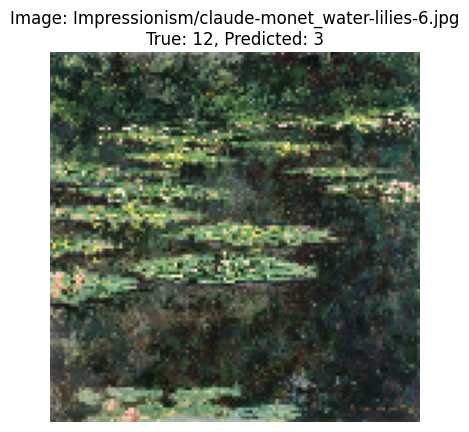

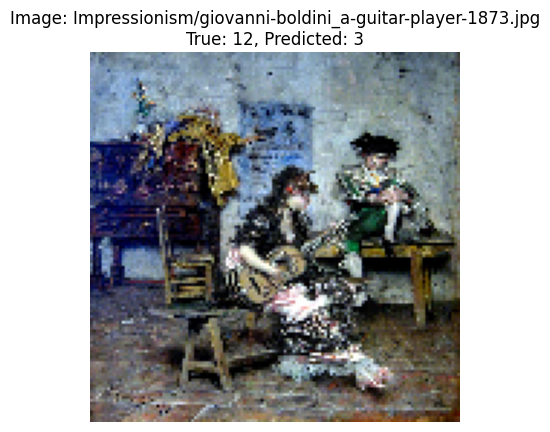

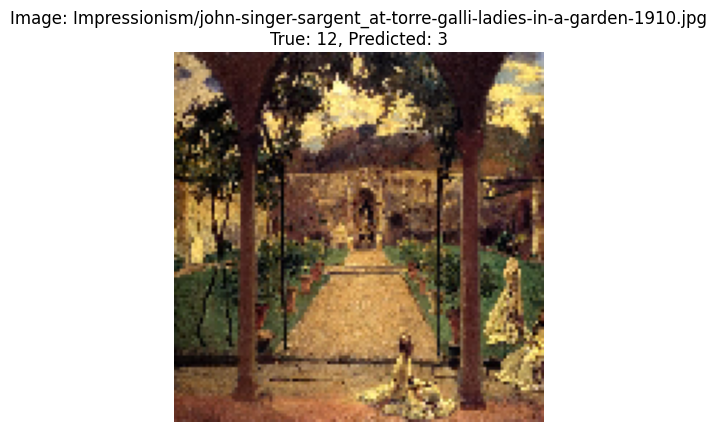

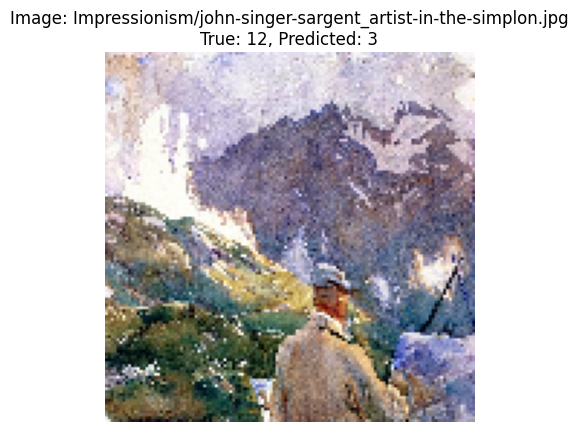

In [188]:
# 计算哪些图像被错误分类
incorrect_idx = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

# 获取类别名称
if isinstance(val_gen, ImageLabelGenerator):
    class_names = list(val_gen.class_indices.keys())
else:
    # 手动指定类别名称
    # 设定正确的类别名称（假设有 27 个类别）
    class_names = [
    '0', '1', '2', '3', '4', '5', '6', 
    '7', '8', '9', '10', '11', '12', '13', 
    '14', '15', '16', '17', '18', '19', '20', 
    '21', '22', '23', '24', '25', '26'
]

# 查看前 5 个错误分类的图像
for idx in incorrect_idx[:5]:
    img_path = os.path.join(data_dir, style_val_data.iloc[idx]['image_path'])
    img_name = style_val_data.iloc[idx]['image_path']
    img = load_img(img_path, target_size=img_size)
    plt.imshow(img)
    true_label = class_names[y_true[idx]]
    predicted_label = class_names[y_pred[idx]]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.title(f"Image: {img_name}\nTrue: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
    plt.pause(0.1)  # 让显示过程有一个小的延迟，确保图像渲染


In [189]:
# 训练集生成器和验证集生成器分别是 train_gen 和 val_gen
# 特征提取器：从模型中提取中间层（这里是 'conv2d_2' 层）的特征
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv2d_2').output)

# 获取训练集和验证集的特征
train_features = feature_extractor.predict(train_gen, batch_size=batch_size)
val_features = feature_extractor.predict(val_gen, batch_size=batch_size)

# 展平特征并进行归一化
train_features = normalize(train_features.reshape(train_features.shape[0], -1))
val_features = normalize(val_features.reshape(val_features.shape[0], -1))

# 将训练集和验证集的特征合并
features = np.vstack([train_features, val_features])

# 获取标签
y_true = np.concatenate([batch_labels for _, batch_labels in train_gen])  # 从 train_gen 获取真实标签
y_pred_classes = np.concatenate([np.argmax(model.predict(batch_images), axis=-1) for batch_images, _ in train_gen])  # 获取模型预测的标签

labels = np.concatenate([y_true, y_pred_classes])

# PCA 降维
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# 绘制PCA降维结果
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='jet', alpha=0.5)
plt.colorbar()
plt.title('PCA visualization of features')
plt.show()

# t-SNE 降维
tsne = TSNE(n_components=2)
reduced_tsne_features = tsne.fit_transform(features)

# 绘制t-SNE降维结果
plt.scatter(reduced_tsne_features[:, 0], reduced_tsne_features[:, 1], c=labels, cmap='jet', alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of features')
plt.show()


ValueError: The layer sequential_10 has never been called and thus has no defined input.

In [ ]:
# # 进行一次预测以确保模型的输入已被初始化
# _ = model.predict(train_gen, batch_size=batch_size)

# # 确保层名称正确
# print("Model Layers:")
# for layer in model.layers:
#     print(layer.name)

# # 提取中间层的特征
# feature_extractor = Model(inputs=model.input, outputs=model.get_layer('conv2d_3').output)

# 提取训练集和验证集的特征
# train_features = feature_extractor.predict(train_gen, batch_size=batch_size)
# val_features = feature_extractor.predict(val_gen, batch_size=batch_size)

# # 标准化特征
# train_features = normalize(train_features.reshape(train_features.shape[0], -1))  # 扁平化并标准化
# val_features = normalize(val_features.reshape(val_features.shape[0], -1))

# # 存储文件名以便后续可视化
# train_filenames = train_gen.filenames
# val_filenames = val_gen.filenames

# def pictures(test_idx):
#     test_feature = val_features[test_idx].reshape(1, -1)
#     my_distance = cdist(test_feature, train_features, metric='euclidean')[0]
#     nearest_neighbors_idx = np.argpartition(my_distance, 5)[:5]
    
#     plt.figure(figsize=(8, 8))     
#     plt.subplot(2, 3, 1)
#     img = plt.imread(os.path.join(data_dir, style_val_data.iloc[test_idx]['image_path']))
#     plt.imshow(img)
#     plt.title(f"Test Image: {style_val_data.iloc[test_idx]['image_path']}")
#     plt.axis('off')
    
#     for p in range(len(nearest_neighbors_idx)):
#         plt.subplot(2, 3, p + 2)
#         neighbor_image = plt.imread(os.path.join(data_dir, style_val_data.iloc[nearest_neighbors_idx[p]]['image_path']))
#         plt.imshow(neighbor_image)
#         plt.title(f"Neighbor {p+1}")
#         plt.axis('off')
    
#     plt.show()


In [ ]:
# # 保存模型
# model.save('WikiArt_CNN_LSTM.h5')

# # 加载模型
# from tensorflow.keras.models import load_model
# model = load_model('WikiArt_CNN_LSTM.h5')
